# Energy Analytics Assignment 1

Dhruv, Ernesto, Karthik, Maneesh

This notebook is intended to complement the PDF submitted as a solution to Group Assignment 1 for Energy Analytics

# Data Loading and Feature Engineering

### Getting the data from a Github Repo

In [41]:
import pandas as pd
import datetime

url = 'https://raw.githubusercontent.com/ernestomonroy/imperial/master/load_weather_dataset_20200612.csv'
df = pd.read_csv(url, sep=',')
df.columns = ['date','min_t','mean_t','max_t','load','london_min','london_mean','london_max','bristol_min','bristol_mean','bristol_max','leeds_min','leeds_mean','leeds_max','covid_index']
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

df['covid_index'] = df['covid_index'].fillna(method='ffill')
df['covid_index'] = df['covid_index'].fillna(0)
df.tail(5)

,date,min_t,mean_t,max_t,load,london_min,london_mean,london_max,bristol_min,bristol_mean,bristol_max,leeds_min,leeds_mean,leeds_max,covid_index
1256,2020-06-10,10.4,12.9,15.3,23484.020833,9.0,11.5,14.0,11.0,13.5,16.0,9.0,11.5,14.0,70.37
1257,2020-06-11,10.4,13.7,17.1,21509.041667,13.0,16.5,20.0,12.0,14.5,17.0,11.0,13.0,15.0,70.37
1258,2020-06-12,NaN,NaN,NaN,NaN,14.0,18.0,22.0,13.0,17.5,22.0,12.0,14.0,16.0,70.37
1259,2020-06-13,NaN,NaN,NaN,NaN,13.0,18.0,23.0,12.0,15.5,19.0,12.0,17.0,22.0,70.37
1260,2020-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.37


### Patching the missing temperature data with forecasts

In [42]:
#Calculate averages
df['provisional_mean_t'] = (df['london_mean'] + df['bristol_mean'] + df['leeds_mean'])/3
df['provisional_min_t'] = (df['london_min'] + df['bristol_min'] + df['leeds_min'])/3
df['provisional_max_t'] = (df['london_max'] + df['bristol_min'] + df['leeds_max'])/3
mean_df = df.copy()
mean_df.drop(mean_df.columns.difference(['provisional_mean_t', 'provisional_min_t', 'provisional_max_t', 'mean_t','min_t','max_t']), axis=1, inplace=True)
mean_df.dropna(inplace=True)
#Develop a correlation model
import statsmodels.api as sm
import statsmodels.formula.api as smf
correl = smf.ols(formula='mean_t ~ provisional_mean_t', data=mean_df)
mean_correlation = correl.fit()
correl = smf.ols(formula='min_t ~ provisional_min_t', data=mean_df)
min_correlation = correl.fit()
correl = smf.ols(formula='max_t ~ provisional_max_t', data=mean_df)
max_correlation = correl.fit()
#Apply correlation model to the mean_t missing values
df['mean_t'] = df['mean_t'].fillna((df['provisional_mean_t']*mean_correlation.params.provisional_mean_t + mean_correlation.params.Intercept))
df['min_t'] = df['min_t'].fillna((df['provisional_min_t']*min_correlation.params.provisional_min_t + min_correlation.params.Intercept))
df['max_t'] = df['max_t'].fillna((df['provisional_max_t']*max_correlation.params.provisional_max_t + max_correlation.params.Intercept))

### Adding time parameters

In [43]:
### ADDING OTHER PARAMETERS
import numpy as np
df['temp_index'] = df['date']
df.index = df['temp_index']
df['weekday'] = df.index.weekday
df['weekend'] = df['weekday'].apply(lambda x: 1 if x in [5,6] else 0)
df['month'] = df.index.month
df['day_of_the_week'] = df.index.dayofweek
# 23rd of march lockdown
df['lockdown'] = df['date'] > '	2020-03-23'
df['lockdown'] = df['lockdown'].apply(lambda x: 1 if x else 0)
#Reset
df.drop(['temp_index'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.sort_values(by=['date'], inplace=True)
#Log of load
df['log_load'] = np.log(df['load'])
#Autoregression
auto_regression_days = 14
for i in range(1,auto_regression_days + 1):
  # Past week autoregression
  df['load_m_' + str(i)] = df['log_load'].shift(i)

### ADDING BANK HOLIDAYS
import datetime
def is_bank_holiday(in_date):
  #New year - Falls on 1 January unless this is a Saturday or Sunday
  if in_date.day == 1 and in_date.dayofweek not in [5,6] and in_date.month == 1:
    return 1
  if in_date.day == 2 and in_date.dayofweek == 0 and in_date.month == 1:
    return 1
  if in_date.day == 3 and in_date.dayofweek == 0 and in_date.month == 1:
    return 1
  #Good Friday   10 april 2020, 19 april 2019, 30 March 2018, 14 April 2017
  #Easter Monday 13 April 2020, 22 April 2019, 2  April 2018, 17 April 2017
  easter_dates = [
    datetime.date(2020, 4, 10),
    datetime.date(2020, 4, 13),
    datetime.date(2019, 4, 19),
    datetime.date(2019, 4, 22),
    datetime.date(2018, 3, 30),
    datetime.date(2018, 4, 2),
    datetime.date(2017, 4, 14),
    datetime.date(2017, 4, 17)
  ]
  if in_date in easter_dates:
    return 1
  #May day - First monday may
  if in_date.dayofweek == 0 and in_date.month == 5 and in_date.day <=7:
    return 1
  #Spring day - Last monday may
  if in_date.dayofweek == 0 and in_date.month == 5 and in_date.day >=25:
    return 1
  #Summer day - Last monday august
  if in_date.dayofweek == 0 and in_date.month == 8 and in_date.day >=25:
    return 1
  #Christmas - 2 days on or after 25th (not weekend)
  if in_date.day in [25, 26] and in_date.dayofweek not in [5,6] and in_date.month == 12:
    return 1
  if in_date.day == 27 and in_date.dayofweek in [0,1] and in_date.month == 12:
    return 1
  if in_date.day == 28 and in_date.dayofweek == 1 and in_date.month == 12:
    return 1

  return 0

df['bank_holiday'] = df['date'].apply(is_bank_holiday)
df.drop(['london_min','london_mean','london_max','bristol_min','bristol_mean',
         'bristol_max','leeds_min','leeds_mean','leeds_max','provisional_mean_t',
         'provisional_min_t','provisional_max_t'], 
                axis=1, inplace=True)

### Exploratory Data Analysis

In [12]:
dfg =df.copy()
dfg.index=pd.to_datetime(dfg.temp_index)
dfg['Year'] = dfg.index.year
dfg['Month'] = dfg.index.month
dfg['Weekday Name'] = dfg.index.weekday

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc880d79e8>],
      dtype=object)

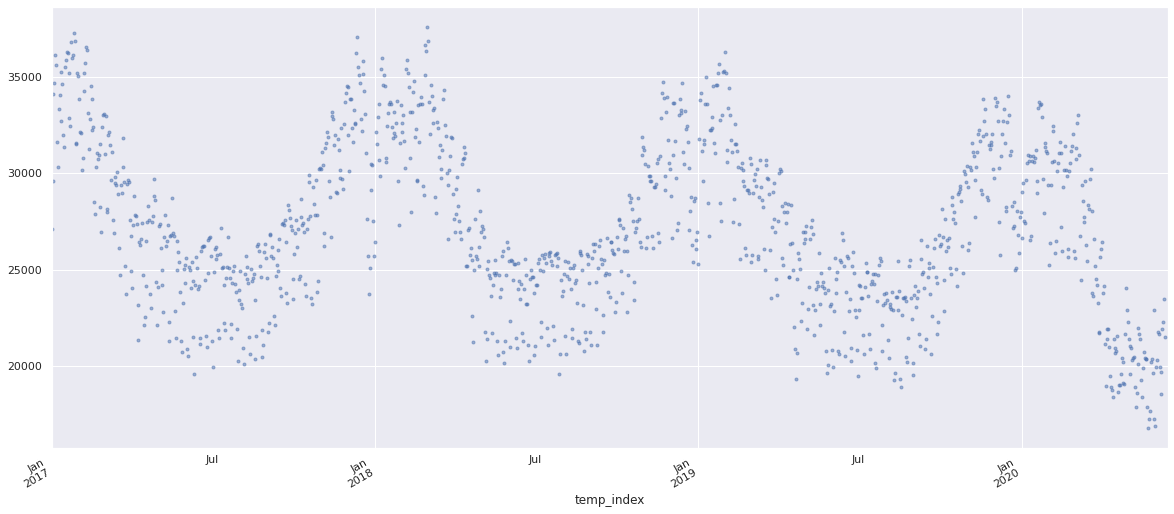

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(12, 8)})

dfg.load.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 9), subplots=True)

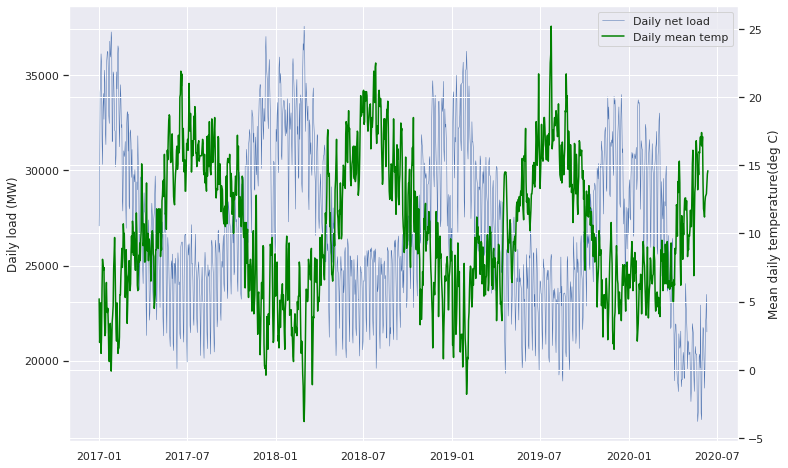

In [14]:

fig, ax = plt.subplots()
ax2=ax.twinx()
#ax2.legend();
ax2.plot(dfg.mean_t,#.resample('M').mean(), 
marker='', linestyle='-', color = 'green',label='Daily mean temp')
#ax.legend();
ax.plot(dfg.load,#.resample('M').sum(),
marker='', linestyle='-', linewidth=0.5, label='Daily net load')
ax.set_ylabel('Daily load (MW)')
ax2.set_ylabel("Mean daily temperature(deg C)")

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)



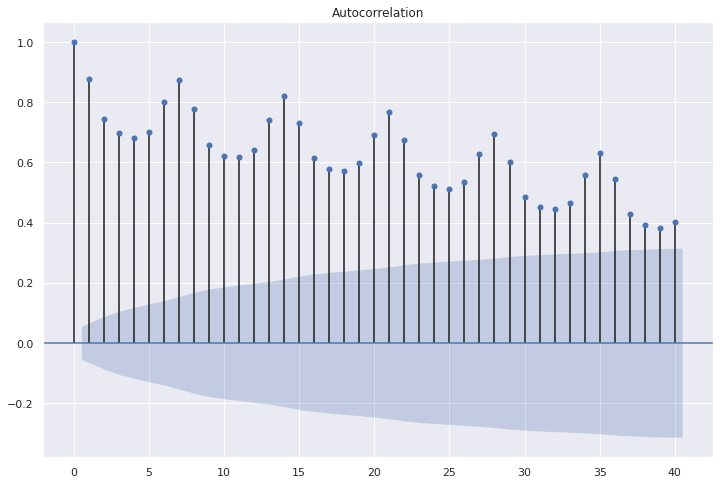

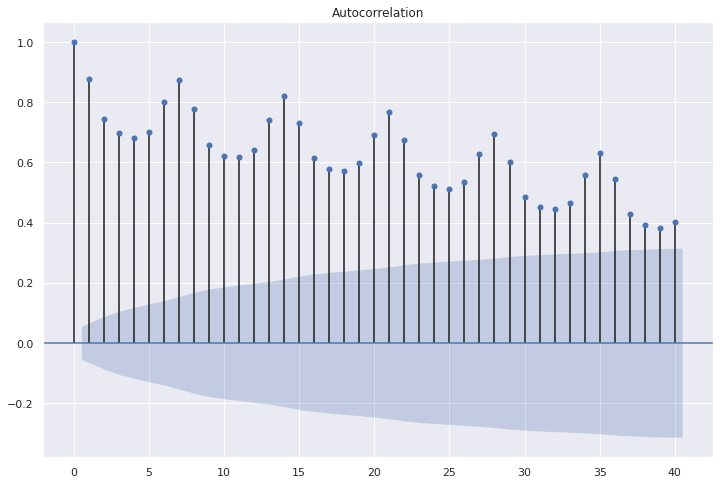

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
df_ts = dfg[~dfg['load'].isna()].copy()
plot_acf(df_ts["load"], lags=40)


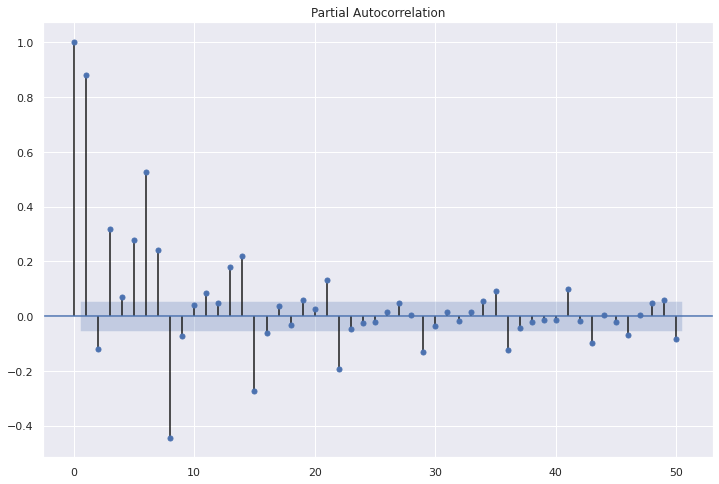

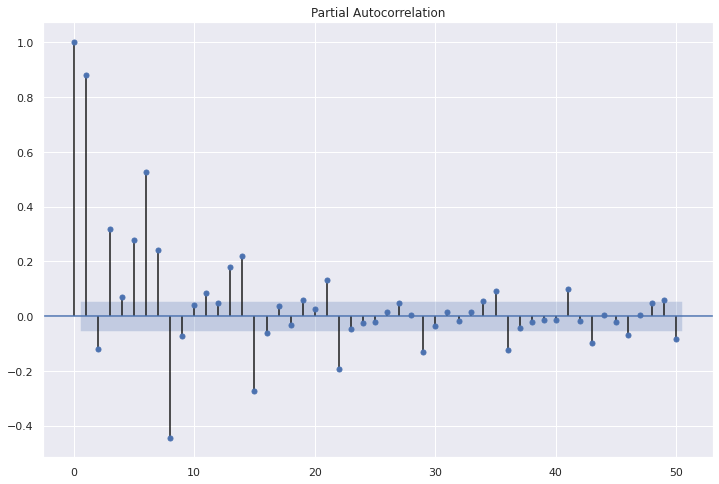

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_ts["load"], lags=50)

Text(0.5, 1.0, 'Day of the Week periodicity')

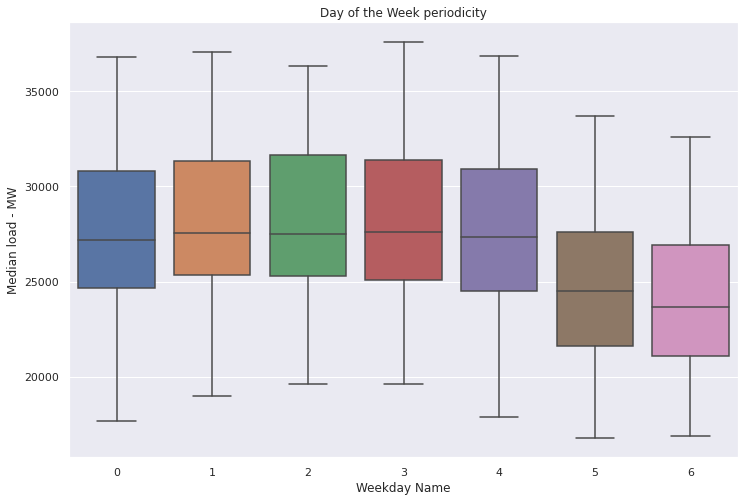

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data=dfg[['Weekday Name','load']], x='Weekday Name', y='load')
ax.set_ylabel('Median load - MW')
ax.set_title('Day of the Week periodicity')

Text(0.5, 1.0, 'Monthly periodicity')

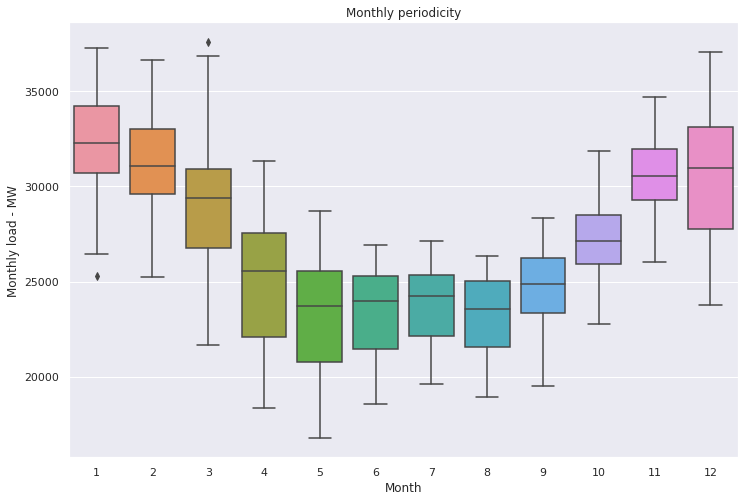

In [18]:
fig, ax = plt.subplots()
sns.boxplot(data=dfg, x='Month', y='load')
ax.set_ylabel('Monthly load - MW')
ax.set_title('Monthly periodicity')

Text(0.5, 0, 'Week No.')

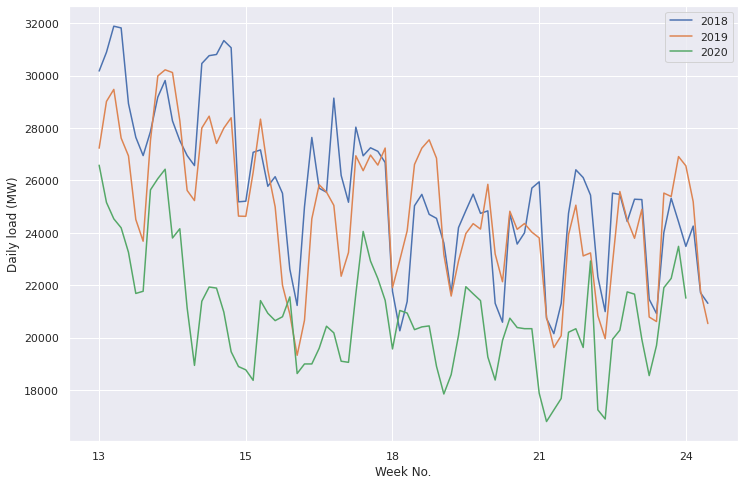

In [19]:
import warnings
warnings.filterwarnings('ignore')
data18 = dfg["20180326":"20180617"]
data19 = dfg["20190325":"20190616"]
data20 = dfg["20200323":"20200614"]

data18['week'] = data18.index.to_series().dt.strftime('%V')
data18.rename(columns={'load': '2018'}, inplace=True)

data19['week'] = data19.index.to_series().dt.strftime('%V')
data19.rename(columns={'load': '2019'}, inplace=True)

data20['week'] = data20.index.to_series().dt.strftime('%V')
data20.rename(columns={'load': '2020', 'covid_index': 'LockdownStringency'}, inplace=True)

ax = data18.plot(x='week', y='2018')
ax = data19.plot(x='week', y='2019', ax=ax)
ax = data20.plot(x='week', y='2020', ax=ax)
ax.set_ylabel('Daily load (MW)')
ax.set_xlabel('Week No.')

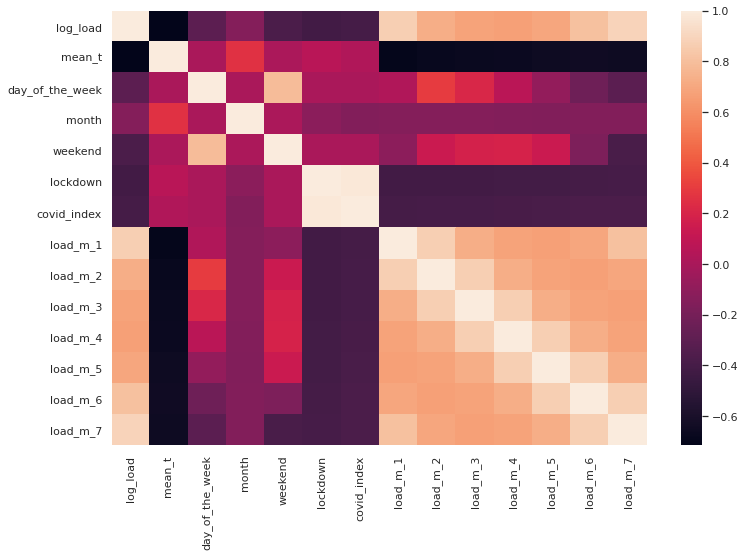

In [20]:
from statsmodels.graphics.correlation import plot_corr
df_cor = df[['log_load','mean_t','day_of_the_week','month','weekend','lockdown','covid_index','load_m_1','load_m_2','load_m_3','load_m_4','load_m_5','load_m_6','load_m_7']].copy()

sns.heatmap(df_cor.corr())


## Custom Scoring function

In [21]:
from scipy.stats import norm
import numpy as np

def log_score(y_train, y_train_predict , y_test, y_test_predict):
  if len(y_train) == len(y_train_predict) and len(y_test) == len(y_test_predict):
    y_train = np.array(y_train)
    y_train_predict = np.array(y_train_predict)
    y_test = np.array(y_test)
    y_test_predict = np.array(y_test_predict)

    sigma = np.std(y_train_predict - y_train)
    scores = []
    for i in range(len(y_test)):
      scores += [norm(y_test_predict[i], sigma).logpdf(y_test[i])]
    print(sigma)
    return scores
  else:
    raise ValueException("Inputs are not equivalent") 

## Splitting the data for training and testing

In [22]:
from sklearn.model_selection import train_test_split

df_no_nan = df.copy()
df_no_nan.dropna(inplace = True)
df_no_nan.drop(['load', 'temp_index', 'date'],axis=1, inplace=True)
y = df_no_nan['log_load']
X = df_no_nan.drop(['log_load'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Rejoin X and y for regressions that use formulae
df_test = X_test.copy()
df_test['log_load'] = y_test
df_train = X_train.copy()
df_train['log_load'] = y_train

#Convert categorical to dummy
X_train = pd.get_dummies(X_train, columns=['day_of_the_week','month','weekday'])
X_test = pd.get_dummies(X_test, columns=['day_of_the_week','month','weekday'])

# Variable Selection

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm


auto_regression_days = 6
ols_formula = 'log_load ~ mean_t + C(month) + covid_index + weekend*lockdown + bank_holiday + '
ols_formula += ' + '.join(['lockdown*load_m_' + str(i) for i in range(1,auto_regression_days+1)])

#Train the model
model = smf.ols(formula=ols_formula, data=df_train).fit()
#Predict the train data for the error 
y_train_predict = model.predict(df_train)
#Predict unseen data
y_test_predict = model.predict(df_test)

#Score
scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.03731611306184172


1.8632865024168108

Average scores by 

Number of autoregressors
4. -0.446
5. 0.36270
6. 0.41963
7. 0.45138
8. 0.14996
9. -0.38233

Autoregressor cross
 - autoregressor*lockdown 1.12665
 - autoregressor 0.94406

Lockdown binary
 - lockdown 1.12665
 - no lockdown 1.12665

Function covid_index:
 - covid_index 1.2665
 - covid_index^0.5 1.12913
 - covid_index^2 1.1183

Varying the temperature variables
 - Only mean 0.53997
 - Mean Max Min 0.45138
 - Mean Max 0.38434
 - Max 0.308886

Bank Holiday
 - No BH 0.60005
 - BH*lockdown 0.53997
 - BH 0.521257

DoW or Weekend
 - No WE, DoW*lockdown 0.44629
 - No WE, DoW 0.92404
 - No WE, No DoW 1.12665
 - WE, No DoW 1.02766
 - WE*lockdown 1.05082 





# Algorithm Selection

### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

model = LinearRegression()
model.fit(X_train,y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.03513260111218342


1.9737892326362059

### Ridge Regression

In [26]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Ridge(solver = 'cholesky')
param_grid = {'alpha': [0.01, 0.1, 0.5, 1]}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.035155891200061254


1.9739173924298201

### Lasso Regression

In [27]:
from sklearn.linear_model import Lasso

model = Lasso()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1]}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.07204395818447142


1.1542465376117441

### Elastic Net Regression

In [28]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'l1_ratio':[0,0.25,0.5,0.75,1]}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.04055872577373228


1.808370787561534

### Linear SVM

In [29]:
from sklearn.svm import LinearSVR

model = LinearSVR()
param_grid = {'epsilon': [0, 0.5, 1, 1.5, 2, 2.5, 3]}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.03919548777686765


1.5671226104549723

### Regression Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
param_grid = {'max_depth': range(1,20)}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.03076315657615314


0.8233156414442561

### Regression Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
param_grid = {'max_depth': [1,2,3,5,8,10,15,20],'n_estimators':[10,100,500,1000,2000]}
search = GridSearchCV(model, param_grid, cv=5)

search.fit(X_train,y_train)
y_train_predict = search.predict(X_train)
y_test_predict = search.predict(X_test)

scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

0.0928831382861445


0.8578216772277639

### Artificial Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=[len(X_train.columns)]))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1))

optimizer = tf.keras.optimizers.Adagrad(0.001)
loss = tf.keras.losses.MeanAbsolutePercentageError(reduction="auto", name="mean_absolute_percentage_error")

model.compile(loss = loss, optimizer = optimizer)

history = model.fit(X_train, y_train, epochs=2000, validation_split = 0.2, verbose=0)

y_train_predict = model.predict(X_train).flatten()
y_test_predict = model.predict(X_test).flatten()
scores = log_score(y_train, y_train_predict , y_test, y_test_predict)
sum(scores)/len(scores)

# Final Model

In [39]:
auto_regression_days = 7
ols_formula = 'log_load ~ min_t + max_t + mean_t + C(month) + covid_index + weekend + '
ols_formula += ' + '.join(['lockdown*load_m_' + str(i) for i in range(1,auto_regression_days+1)])

#Train the model
model = smf.ols(formula=ols_formula, data=df_no_nan)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               log_load   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     559.7
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:20:35   Log-Likelihood:                 2225.2
No. Observations:                1244   AIC:                            -4386.
Df Residuals:                    1212   BIC:                            -4222.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3220      0.26

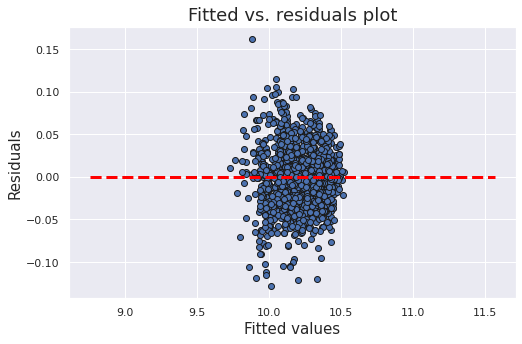

In [33]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=res.fittedvalues,y=res.resid,edgecolor='k')
xmin=min(res.fittedvalues)
xmax = max(res.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()


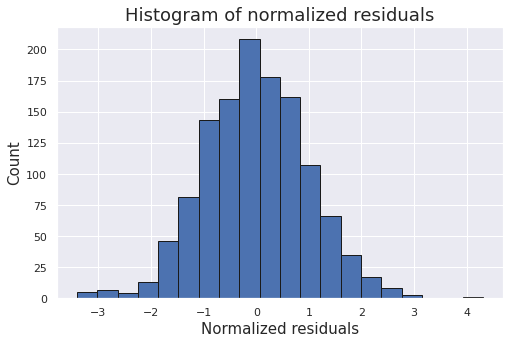

In [34]:
plt.figure(figsize=(8,5))
plt.hist(res.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

<Figure size 576x360 with 0 Axes>

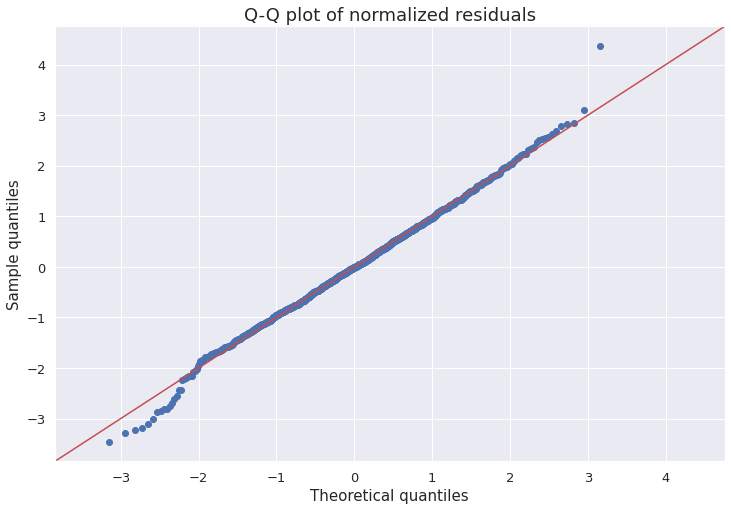

In [35]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(res.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [36]:
from scipy.stats import shapiro
_,p=shapiro(res.resid)
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The normality assumption may not hold


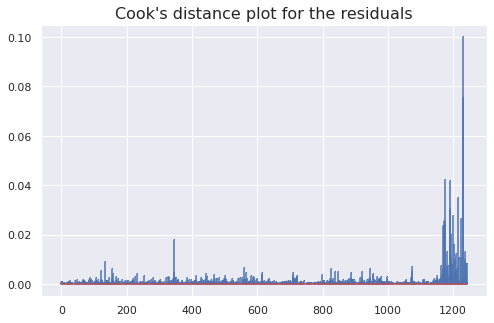

In [37]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(res)
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()